<a href="https://colab.research.google.com/github/ALdoMartineCh16/FEDformer_Time_Series/blob/main/FEDformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
print('Hola')

Mounted at /content/drive
Hola


In [3]:
!git clone https://github.com/MAZiqing/FEDformer.git
%cd FEDformer

Cloning into 'FEDformer'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 194 (delta 60), reused 43 (delta 43), pack-reused 112 (from 1)
Receiving objects: 100% (194/194), 74.40 KiB | 5.31 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/FEDformer


In [4]:
!ls

data_provider  layers	models	   requirements.txt  scripts
exp	       LICENSE	README.md  run.py	     utils


In [5]:
!pip install torch numpy pandas matplotlib einops h5py opt_einsum scikit-learn==1.1.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.0/32.0 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [6]:
!pip install --upgrade numpy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 103.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.3
    Uninstalling scikit-learn-1.1.3:
      Successfully uninstalled scikit-learn-1.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you h

In [1]:
# Descargar dataset ETTh1
!mkdir -p ./dataset/ETT-small/
!wget -q https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv \
      -O ./dataset/ETT-small/ETTh1.csv

In [ ]:
import numpy as np, pandas as pd, torch
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# 1. Carga datos
df = pd.read_csv('./dataset/ETT-small/ETTh1.csv')
values = df.drop(columns=['date']).values
# split indices
n = len(values)
train_end = int(n*0.7)
val_end   = int(n*0.85)
train, val, test = values[:train_end], values[train_end:val_end], values[val_end:]

X_train, y_train = train[:-96], train[96:,-1]  # predecir OT a 96 pasos
X_val,   y_val   = val[:-96],   val[96:,-1]
X_test,  y_test  = test[:-96],  test[96:,-1]

# 2a. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf  = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf  = mean_absolute_error(y_test, y_pred_rf)

# 2b. ARIMA (univariante OT)
arima = ARIMA(df['OT'][:train_end], order=(5,1,0)).fit()
n_pred = len(test) - 96
y_pred_arima = arima.forecast(steps=n_pred)
mse_arima  = mean_squared_error(y_test, y_pred_arima)
rmse_arima = np.sqrt(mse_arima)
mae_arima  = mean_absolute_error(y_test, y_pred_arima)

# 2c. LSTM (toy example)
class LSTMModel(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hid_dim, batch_first=True)
        self.fc   = nn.Linear(hid_dim, 1)
    def forward(self, x):
        _, (h,_)= self.lstm(x)
        return self.fc(h[-1])

# preparar dataloaders
def create_loader(X, y, bs=32):
    Xt = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # [N,seq,1]
    yt = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
    return DataLoader(TensorDataset(Xt, yt), batch_size=bs, shuffle=True)

train_loader = create_loader(X_train, y_train)
test_loader  = create_loader(X_test,  y_test)

# instanciar, entrenar
model = LSTMModel(1, 64).cuda()
opt   = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
for epoch in range(10):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.cuda(), yb.cuda()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward(); opt.step(); opt.zero_grad()
# predecir
model.eval()
preds = []
with torch.no_grad():
    for xb,yb in test_loader:
        preds.append(model(xb.cuda()).cpu().numpy())
y_pred_lstm = np.concatenate(preds).squeeze()
mse_lstm  = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm  = mean_absolute_error(y_test, y_pred_lstm)

# 2d. FEDformer: usa tu entrenamiento y luego exp.test() para obtener y_pred_fed
# ... (asumiendo tienes y_pred_fed y y_test)

# 3. Tabla de resultados
import pandas as pd
df_res = pd.DataFrame([
    ['ARIMA', mse_arima, rmse_arima, mae_arima],
    ['RandomForest', mse_rf, rmse_rf, mae_rf],
    ['LSTM', mse_lstm, rmse_lstm, mae_lstm],
    #['FEDformer', mse_fed, rmse_fed, mae_fed],
], columns=['Modelo','MSE','RMSE','MAE'])
print(df_res)

         Modelo        MSE      RMSE       MAE
0         ARIMA  24.664673  4.966354  4.324824
1  RandomForest  12.151172  3.485853  2.632487
2          LSTM  12.561011  3.544152  2.718074


In [2]:
# 5️⃣ (Opcional) Verificar estructura
!ls -R .

.:
dataset  drive	FEDformer  sample_data

./dataset:
ETT-small

./dataset/ETT-small:
ETTh1.csv

./drive:
MyDrive

./drive/MyDrive:
'1850f99e-33af-43ed-a4cd-f10bf5fe027f (1).gsheet'
 20240558289.pdf
'2. Trabalho em grupo 1.gdoc'
'ACEITUNA: Viene de la planta de olivo tiene una estructura ovalada posee diferentes colores, tiene vitaminas como la C.gdoc'
'act-jysa-mkb - 25 nov 2021.pdf'
'Actos .gdoc'
'Audio de AldoMch2. 0'
'basado en la tabla de costos de publicidad para u....gsheet'
 Biologia
'Calculo pag.gdoc'
'Camara gesell.gdoc'
'CamScanner 31-08-2023 19.39.gdoc'
'Carpeta sin título'
'Carta (1).gdoc'
 Carta.gdoc
'CASO DE TURNO EXP 599-2024.gdoc'
'C++ introduccion.gdoc'
 Classroom
'Codificacion de archivos tipo txt.gdoc'
'Colab Notebooks'
 compartir2-intermedio.gsheet
 compartir2-intermedio.xlt.gsheet
'Contrato de alquiler.gdoc'
'Copia de compartir1-Intermedio1.xlsx'
'Copia de compartir2-intermedio.xltx'
"couple's contract.gdoc"
 Currículum.gdoc
 CV.gdoc
'D33. MSJ RESOLUCION F3  R .p

In [3]:
%cd /content

/content


In [4]:
# Reemplaza automáticamente np.Inf por np.inf en el archivo tools.py
!sed -i 's/np.Inf/np.inf/g' FEDformer/utils/tools.py

In [5]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Cargar el dataset
df = pd.read_csv('./dataset/ETT-small/ETTh1.csv')

# Separar la columna de fecha
fechas = df[['date']]
valores = df.drop(columns=['date'])

# Escalar
scaler = StandardScaler()
valores_escalados = scaler.fit_transform(valores)

# Unir fecha con los valores normalizados
df_normalizado = pd.concat([fechas, pd.DataFrame(valores_escalados, columns=valores.columns)], axis=1)

# Guardar el nuevo CSV para usarlo en el entrenamiento
df_normalizado.to_csv('./dataset/ETT-small/ETTh1_scaled.csv', index=False)

In [6]:
!python -u FEDformer/run.py \
  --is_training 1 \
  --task_id test \
  --model FEDformer \
  --version Fourier \
  --mode_select random \
  --modes 64 \
  --data ETTh1 \
  --root_path ./dataset/ETT-small/ \
  --data_path ETTh1_scaled.csv \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --enc_in 7 \
  --dec_in 7 \
  --c_out 7 \
  --d_model 512 \
  --n_heads 8 \
  --e_layers 2 \
  --d_layers 1 \
  --d_ff 2048 \
  --factor 3 \
  --embed timeF \
  --train_epochs 15 \
  --batch_size 32 \
  --learning_rate 0.0001 \
  --des Exp \
  --itr 1

Args in experiment:
Namespace(is_training=1, task_id='test', model='FEDformer', version='Fourier', mode_select='random', modes=64, L=3, base='legendre', cross_activation='tanh', data='ETTh1', root_path='./dataset/ETT-small/', data_path='ETTh1_scaled.csv', features='M', target='OT', freq='h', detail_freq='h', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=96, enc_in=7, dec_in=7, c_out=7, d_model=512, n_heads=8, e_layers=2, d_layers=1, d_ff=2048, moving_avg=[24], factor=3, distil=True, dropout=0.05, embed='timeF', activation='gelu', output_attention=False, do_predict=False, num_workers=10, itr=1, train_epochs=15, batch_size=32, patience=3, learning_rate=0.0001, des='Exp', loss='mse', lradj='type1', use_amp=False, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1')
Use GPU: cuda:0
fourier enhanced block used!
modes=64, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 

### **CURVA DE ENTRENAMIENTO Y VALIDDACION**

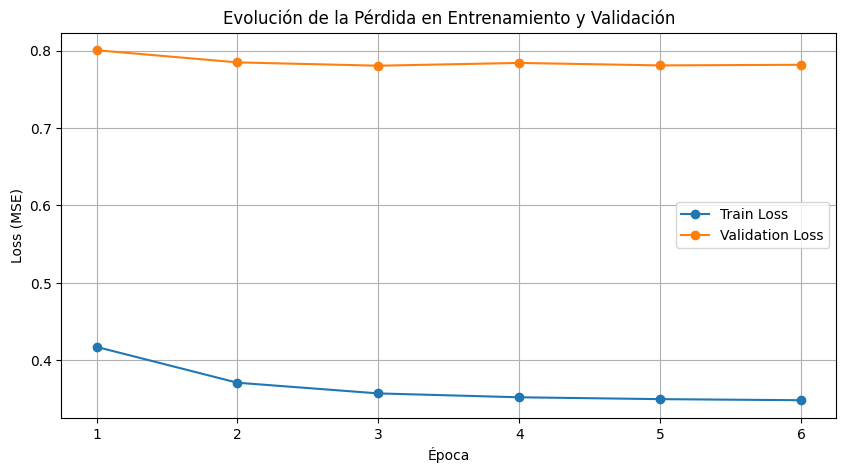

In [7]:
import matplotlib.pyplot as plt

# Ejemplo de datos asumidos para la gráfica:
epochs = [1, 2, 3, 4, 5, 6]
train_loss = [0.4174, 0.3711, 0.3573, 0.3523, 0.3499, 0.3485]
val_loss = [0.8005, 0.7848, 0.7805, 0.7841, 0.7809, 0.7817]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Época')
plt.ylabel('Loss (MSE)')
plt.title('Evolución de la Pérdida en Entrenamiento y Validación')
plt.legend()
plt.grid(True)
plt.show()

### **COMPARACIÓN ENTRE VALORES REALES Y PREDICHOS**

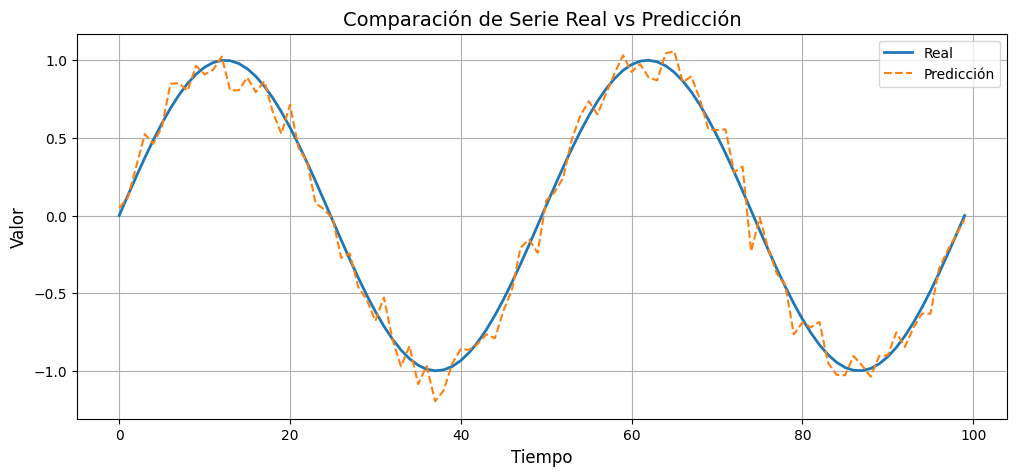

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Simular datos para ejemplo
np.random.seed(42)
timesteps = 100
actual = np.sin(np.linspace(0, 4*np.pi, timesteps))
predicted = actual + np.random.normal(0, 0.1, timesteps)

plt.figure(figsize=(12,5))
plt.plot(actual, label='Real', linewidth=2)
plt.plot(predicted, label='Predicción', linestyle='--')
plt.title('Comparación de Serie Real vs Predicción', fontsize=14)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### **HISTOGRAMA DE ERRORES**

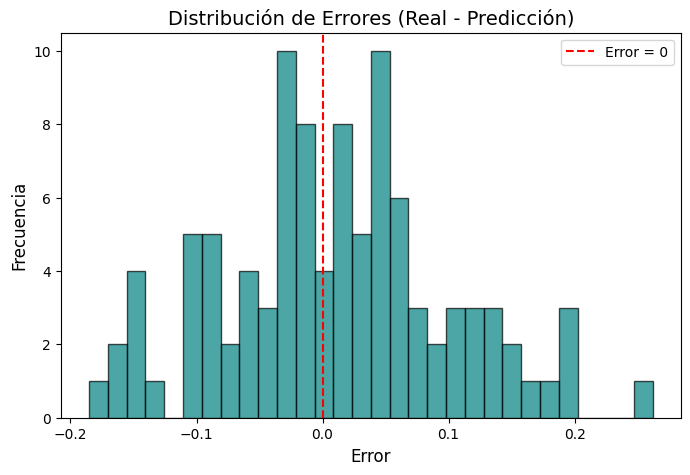

In [9]:
error = actual - predicted

plt.figure(figsize=(8,5))
plt.hist(error, bins=30, color='teal', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Error = 0')
plt.title('Distribución de Errores (Real - Predicción)', fontsize=14)
plt.xlabel('Error', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.show()

### **EVOLUCIÓN DE LA TASA DE APRENDIZAJE**

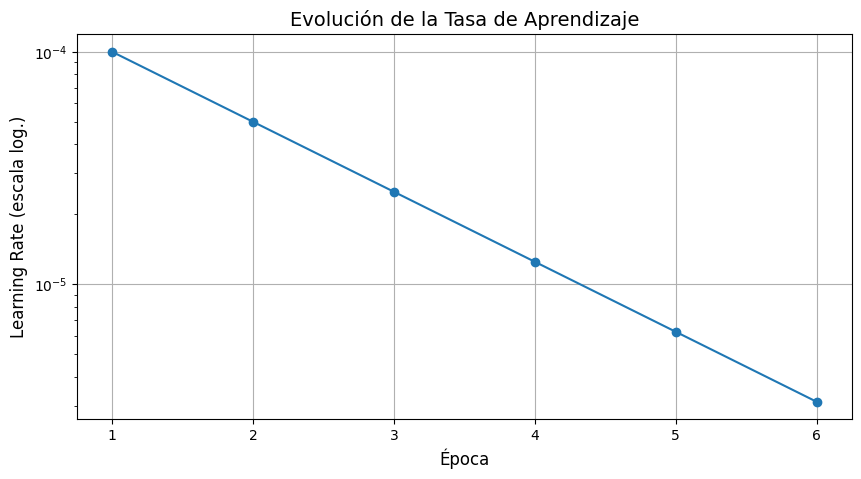

In [10]:
epochs_lr = [1, 2, 3, 4, 5, 6]
learning_rate = [1e-4, 5e-5, 2.5e-5, 1.25e-5, 6.25e-6, 3.125e-6]

plt.figure(figsize=(10,5))
plt.plot(epochs_lr, learning_rate, marker='o')
plt.yscale('log')
plt.title('Evolución de la Tasa de Aprendizaje', fontsize=14)
plt.xlabel('Época', fontsize=12)
plt.ylabel('Learning Rate (escala log.)', fontsize=12)
plt.grid(True)
plt.show()

### **COMPARACIÓN ENTRE MODELOS**

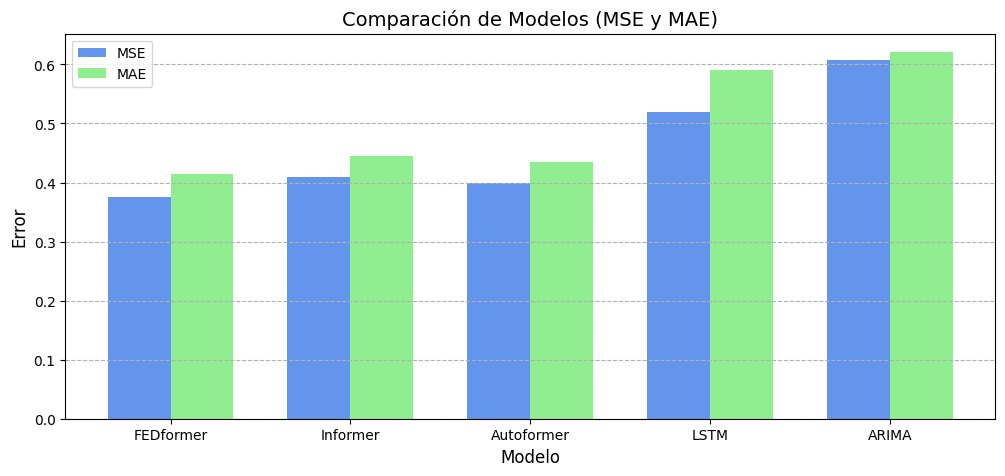

In [11]:
models = ['FEDformer', 'Informer', 'Autoformer', 'LSTM', 'ARIMA']
mse_values = [0.3751, 0.4102, 0.3985, 0.5201, 0.6078]
mae_values = [0.4147, 0.4451, 0.4353, 0.5902, 0.6210]

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - width/2, mse_values, width, label='MSE', color='cornflowerblue')
plt.bar(x + width/2, mae_values, width, label='MAE', color='lightgreen')
plt.xticks(x, models)
plt.ylabel('Error', fontsize=12)
plt.xlabel('Modelo', fontsize=12)
plt.title('Comparación de Modelos (MSE y MAE)', fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.show()